In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import 
from tensorflow.keras.utils import plot_model

In [2]:
!nvidia-smi

Thu May  6 12:48:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   37C    P8    16W / 150W |      0MiB /  7618MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
base_dir = './findog'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
        rescale=1/255,    
#        rotation_range=40,
#        width_shift_range=0.1,
#        height_shift_range=0.1,
#        zoom_range=0.2,
#        horizontal_flip=True,
#        vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
     rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical'
)

Found 10957 images belonging to 120 classes.
Found 2679 images belonging to 120 classes.
Found 0 images belonging to 120 classes.


IndexError: list index out of range

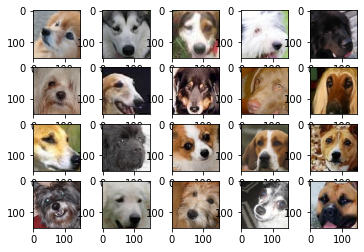

In [4]:
fig = plt.figure()
fig_arr = []
for i in range(20):
    fig_arr.append(fig.add_subplot(4,5,i+1))

for data_batch, lable_batch in train_generator:
    for idx, img_data in enumerate(data_batch):
        fig_arr[idx].imshow(img_data, cmap='gray')
    break

plt.tight_layout()
plt.show()

# 전이 학습

In [5]:
# pretrained network
model_base = ResNet101V2(include_top=False, 
                            weights='imagenet', input_shape=(150,150,3))
# model_base의 weight학습을 동결
model_base.trainable=False

model_base.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [6]:
model = Sequential()

# pretrained network를 우리의 모델 앞에 추가
model.add(model_base)

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(120, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 5, 5, 2048)        42626560  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               6144120   
Total params: 48,770,680
Trainable params: 6,144,120
Non-trainable params: 42,626,560
_________________________________________________________________


# Fine Tuning

In [ ]:
'''
model_base.trainable=True

# 상위 layer 동결해제
for layer in model_base.layers:
    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:
        layer.trainable=True
    else:
        layer.trainable=False

# learning_rate 더 작게 설정
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])
'''

In [ ]:
'''
plot_model(model, show_shapes=True, rankdir='TB', dpi=96, 
           to_file='./models/융합프로젝트.png')'''

In [7]:
history = model.fit(train_generator, steps_per_epoch=109, epochs=30,
                    validation_data=validation_generator, validation_steps=26)

Epoch 1/30
109/109 [==============================] - 58s 455ms/step - loss: 6.2540 - accuracy: 0.2822 - val_loss: 1.5542 - val_accuracy: 0.7023
Epoch 2/30
109/109 [==============================] - 47s 431ms/step - loss: 1.5689 - accuracy: 0.7006 - val_loss: 1.5190 - val_accuracy: 0.7281
Epoch 3/30
109/109 [==============================] - 47s 431ms/step - loss: 0.9873 - accuracy: 0.7930 - val_loss: 1.5547 - val_accuracy: 0.7346
Epoch 4/30
109/109 [==============================] - 47s 431ms/step - loss: 0.6594 - accuracy: 0.8412 - val_loss: 1.5594 - val_accuracy: 0.7377
Epoch 5/30
109/109 [==============================] - 47s 431ms/step - loss: 0.4340 - accuracy: 0.8905 - val_loss: 1.6101 - val_accuracy: 0.7415
Epoch 6/30
109/109 [==============================] - 47s 431ms/step - loss: 0.3324 - accuracy: 0.9039 - val_loss: 1.6527 - val_accuracy: 0.7462
Epoch 7/30
109/109 [==============================] - 47s 431ms/step - loss: 0.2334 - accuracy: 0.9324 - val_loss: 1.6956 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


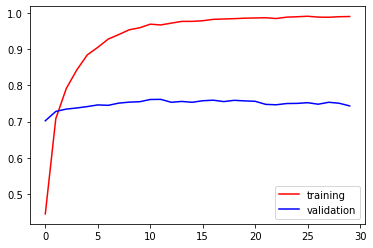

In [8]:
# history 객체 확인
print(history.history.keys())

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(train_acc, color='r', label='training')
plt.plot(validation_acc, color='b', label='validation')
plt.legend()
#plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-1_acc.jpg')
plt.show()

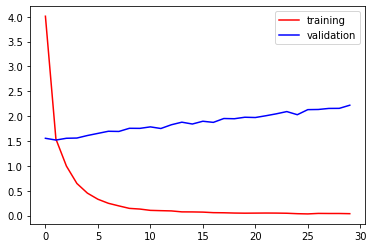

In [9]:
plt.plot(train_loss, color='r', label='training')
plt.plot(validation_loss, color='b', label='validation')
plt.legend()
#plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-1_val.jpg')
plt.show()

In [10]:
result = model.evaluate(validation_generator)
print(np.round(result, 4))

27/27 [==============================] - 11s 385ms/step - loss: 2.2220 - accuracy: 0.7428
[2.222  0.7428]


In [ ]:
#model.save('./models/InceptionResNetV2_1/InceptionResNetV2_1-1.h5')